In [1]:
## Standard libraries
import os
import json
import math
import numpy as np
import time
import copy

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# references - 
# https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial7/GNN_overview.html
# https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

  Preparing metadata (setup.py) ... done
1.13.0+cu116
cuda:0


# Node Classification with Graph Neural Networks
In this notebook, I have implemented and applied **Graph Neural Networks (GNNs) to the task of node classification**.
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).

I have used the `Cora` dataset, which is a **citation network** where nodes represent documents.
The Cora consists of 2708 scientific publications with links between each other representing the citation of one paper by another. The task is to classify each publication into one of seven classes. Each publication is represented by a bag-of-words vector. This means that we have a vector of 1433 elements for each publication, where a 1 at feature $i$ indicates that the $i$-th word of a pre-defined dictionary is in the article. Binary bag-of-words representations are commonly used when we need very simple encodings, and already have an intuition of what words to expect in a network.

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We make use of [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [3]:
node_feats = copy.deepcopy(data.x)
num_nodes = data.num_nodes
num_features = data.num_features

node_feats = node_feats.unsqueeze(0) # adding additional dimension for batch size
print(node_feats.shape)

adj_matrix = torch.zeros((num_nodes, num_nodes))
num_edges = data.num_edges

for i in range(num_edges):
    start_node = data.edge_index[0, i]
    end_node = data.edge_index[1, i]
    adj_matrix[start_node, end_node] = 1

# add self-loops
for i in range(num_nodes):
    adj_matrix[i][i] = 1  

adj_matrix = adj_matrix.unsqueeze(0) # adding additional dimension for batch size
print(adj_matrix.shape)  

torch.Size([1, 2708, 1433])
torch.Size([1, 2708, 2708])


## Using MLP for the Node-Classification task as the baseline
Good practice in node-level tasks is to create an MLP baseline that is applied to each node independently. This way we can verify whether adding the graph information to the model indeed improves the prediction, or not. It might also be that the features per node are already expressive enough to clearly point towards a specific class. To check this, we implement a simple MLP below.

Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


In [5]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

best_model_wts = None
best_val_acc = 0.
best_epoch = 0

for epoch in range(1, 51):
    loss = train()
    val_acc = test(data.val_mask)
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch = epoch

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print(f'Best validation accuracy of {best_val_acc:.4f} was achieved in epoch {best_epoch}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


In [6]:
model.load_state_dict(best_model_wts)
model.eval()

test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5480


As one can see, our MLP performs rather bad with only about 54.8% test accuracy.

But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



Let's visualize the node embeddings of our **trained** MLP network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.
We can see that clusters formed arent good. Thus, we need to consider information from the neighbours as well.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


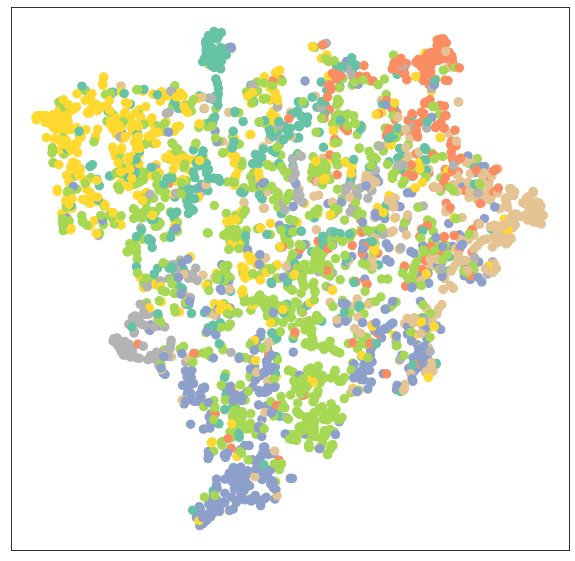

In [7]:
out = model(data.x)
visualize(out, color=data.y)

### Graph Convolutions

Graph Convolutional Networks have been introduced by [Kipf et al.](https://openreview.net/pdf?id=SJU4ayYgl) in 2016 at the University of Amsterdam. GCNs are similar to convolutions in images in the sense that the "filter" parameters are typically shared over all locations in the graph. At the same time, GCNs rely on message passing methods, which means that vertices exchange information with the neighbors, and send "messages" to each other. The first step is that each node creates a feature vector that represents the message it wants to send to all its neighbors. In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node. 
If we want to formulate that in more mathematical terms, we need to first decide how to combine all the messages a node receives. As the number of messages vary across nodes, we need an operation that works for any number. Hence, the usual way to go is to sum or take the mean. Given the previous features of nodes $H^{(l)}$, the GCN layer is defined as follows:

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

$W^{(l)}$ is the weight parameters with which we transform the input features into messages ($H^{(l)}W^{(l)}$). To the adjacency matrix $A$ we add the identity matrix so that each node sends its own message also to itself: $\hat{A}=A+I$. Finally, to take the average instead of summing, we calculate the matrix $\hat{D}$ which is a diagonal matrix with $D_{ii}$ denoting the number of neighbors node $i$ has. $\sigma$ represents an arbitrary activation function, and not necessarily the sigmoid (usually a ReLU-based activation function is used in GNNs). 

When implementing the GCN layer in PyTorch, we can take advantage of the flexible operations on tensors. Instead of defining a matrix $\hat{D}$, we can simply divide the summed messages by the number of neighbors afterward. Additionally, we replace the weight matrix with a linear layer, which additionally allows us to add a bias. Written as a PyTorch module, the GCN layer is defined as follows:

In [8]:
# GCN Layer from scratch using pytorch and without using pytorch-geomtetric
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections.
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [9]:
class GCN_from_scratch(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNLayer(dataset.num_features, hidden_channels)
        self.conv2 = GCNLayer(hidden_channels, dataset.num_classes)

    def forward(self, x, adj_matrix):
        x = self.conv1(x, adj_matrix)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, adj_matrix)
        return x

model = GCN_from_scratch(hidden_channels=16)
print(model)

GCN_from_scratch(
  (conv1): GCNLayer(
    (projection): Linear(in_features=1433, out_features=16, bias=True)
  )
  (conv2): GCNLayer(
    (projection): Linear(in_features=16, out_features=7, bias=True)
  )
)


In [10]:
# a toy example for testing GCN layer

x = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(x, adj)

print("Adjacency matrix", adj)
print("Input features", x)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


However, one issue we can see from looking at the example above is that the output features for nodes 3 and 4 are the same because they have the same adjacent nodes (including itself). Therefore, GCN layers can make the network forget node-specific information if we just take a mean over all messages. Multiple possible improvements have been proposed. While the simplest option might be using residual connections, the more common approach is to either weigh the self-connections higher or define a separate weight matrix for the self-connections. Alternatively, we can use GATs which uses the concept of attention. 

Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


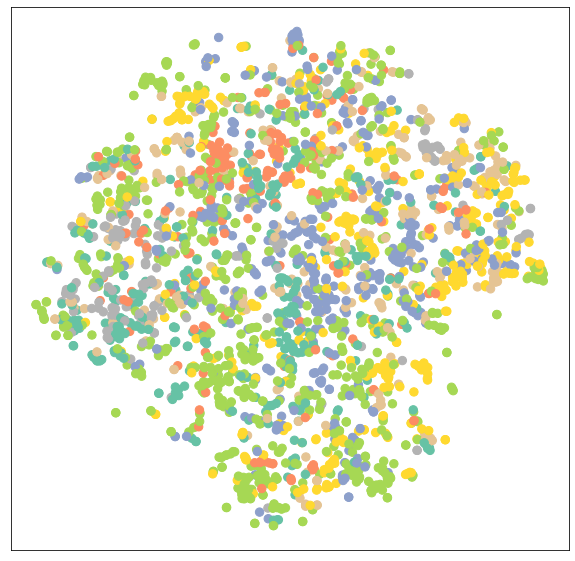

In [11]:
model = GCN_from_scratch(hidden_channels=16)
model.eval()

out = model(node_feats, adj_matrix)
visualize(out[0], color=data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `adj_matrix` as input to our GCN model.

In [13]:
# training the GCN on cora
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN_from_scratch(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(node_feats, adj_matrix)  # Perform a single forward pass.
      out = out[0]
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(node_feats, adj_matrix)  # Perform a single forward pass.
      out = out[0]
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

best_model_wts = None
best_val_acc = 0.
best_epoch = 0

for epoch in range(1, 51):
    loss = train()
    val_acc = test(data.val_mask)
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch = epoch

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print(f'Best validation accuracy of {best_val_acc:.4f} was achieved in epoch {best_epoch}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9506
Epoch: 002, Loss: 1.9465
Epoch: 003, Loss: 1.9419
Epoch: 004, Loss: 1.9387
Epoch: 005, Loss: 1.9322
Epoch: 006, Loss: 1.9265
Epoch: 007, Loss: 1.9198
Epoch: 008, Loss: 1.9138
Epoch: 009, Loss: 1.9096
Epoch: 010, Loss: 1.9014
Epoch: 011, Loss: 1.8950
Epoch: 012, Loss: 1.8841
Epoch: 013, Loss: 1.8792
Epoch: 014, Loss: 1.8721
Epoch: 015, Loss: 1.8658
Epoch: 016, Loss: 1.8515
Epoch: 017, Loss: 1.8372
Epoch: 018, Loss: 1.8371
Epoch: 019, Loss: 1.8170
Epoch: 020, Loss: 1.7989
Epoch: 021, Loss: 1.7966
Epoch: 022, Loss: 1.7787
Epoch: 023, Loss: 1.7720
Epoch: 024, Loss: 1.7639
Epoch: 025, Loss: 1.7366
Epoch: 026, Loss: 1.7152
Epoch: 027, Loss: 1.6993
Epoch: 028, Loss: 1.6831
Epoch: 029, Loss: 1.6778
Epoch: 030, Loss: 1.6414
Epoch: 031, Loss: 1.6153
Epoch: 032, Loss: 1.6120
Epoch: 033, Loss: 1.6039
Epoch: 034, Loss: 1.5814
Epoch: 035, Loss: 1.5360
Epoch: 036, Loss: 1.5216
Epoch: 037, Loss: 1.5353
Epoch: 038, Loss: 1.5009
Epoch: 039, Loss: 1.4807
Epoch: 040, Loss: 1.4449


After training the model, we can check its test accuracy:

In [14]:
# loading the best model wts
model = GCN_from_scratch(hidden_channels=16)
model.load_state_dict(best_model_wts)
model.eval()

test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7500


The TSNE plot of the output embeddings of our **trained** model now produces a far better clustering of nodes of the same category.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


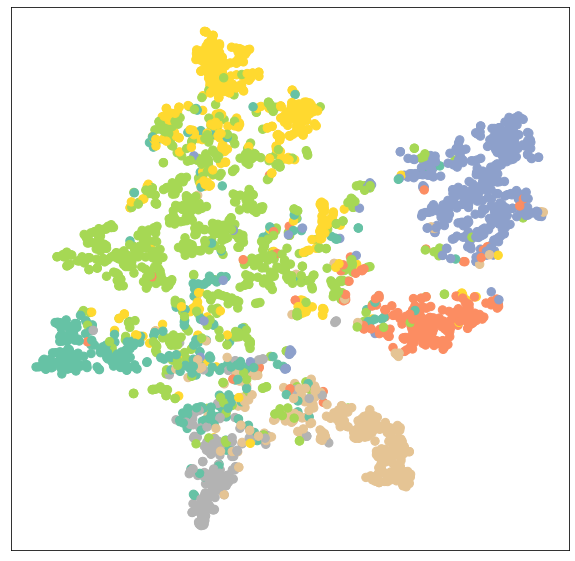

In [15]:
model = GCN_from_scratch(hidden_channels=16)
model.load_state_dict(best_model_wts)
model.eval()

out = model(node_feats, adj_matrix)
visualize(out[0], color=data.y)

###    Implementing GCN using pytorch-geometric

In [16]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [17]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

best_model_wts = None
best_val_acc = 0.
best_epoch = 0

for epoch in range(1, 51):
    loss = train()
    val_acc = test(data.val_mask)
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch = epoch

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print(f'Best validation accuracy of {best_val_acc:.4f} was achieved in epoch {best_epoch}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


Similar accuracy obtained in both implementations of GCN.

In [18]:
# loading the best model wts
model = GCN(hidden_channels=16)
model.load_state_dict(best_model_wts)
model.eval()

test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7800


### Graph Attention 

Attention describes a weighted average of multiple elements with the weights dynamically computed based on an input query and elements' keys. This concept can be similarly applied to graphs, one of such is the Graph Attention Network (called GAT, proposed by [Velickovic et al., 2017](https://arxiv.org/abs/1710.10903)). Similarly to the GCN, the graph attention layer creates a message for each node using a linear layer/weight matrix. For the attention part, it uses the message from the node itself as a query, and the messages to average as both keys and values (note that this also includes the message to itself). The score function $f_{attn}$ is implemented as a one-layer MLP which maps the query and key to a single value.

Let $h_i$ and $h_j$ be the original features from node $i$ and $j$ respectively, and represent the messages of the layer with $\mathbf{W}$ as weight matrix. $\mathbf{a}$ is the weight matrix of the MLP, which has the shape $[1,2\times d_{\text{message}}]$, and $\alpha_{ij}$ the final attention weight from node $i$ to $j$. The calculation can be described as follows:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)\right)}$$

The operator $||$ represents the concatenation, and $\mathcal{N}_i$ the indices of the neighbors of node $i$. Note that in contrast to usual practice, we apply a non-linearity (here LeakyReLU) before the softmax over elements. Although it seems like a minor change at first, it is crucial for the attention to depend on the original input. Specifically, let's remove the non-linearity for a second, and try to simplify the expression:

$$
\begin{split}
    \alpha_{ij} & = \frac{\exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\
\end{split}
$$

We can see that without the non-linearity, the attention term with $h_i$ actually cancels itself out, resulting in the attention being independent of the node itself. Hence, we would have the same issue as the GCN of creating the same output features for nodes with the same neighbors. This is why the LeakyReLU is crucial and adds some dependency on $h_i$ to the attention. 

Once we obtain all attention factors, we can calculate the output features for each node by performing the weighted average:

$$h_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}h_j\right)$$

$\sigma$ is yet another non-linearity, as in the GCN layer. 
To increase the expressiveness of the graph attention network, [Velickovic et al.](https://arxiv.org/abs/1710.10903) proposed to extend it to multiple heads similar to the Multi-Head Attention block in Transformers. This results in $N$ attention layers being applied in parallel.

After having discussed the graph attention layer in detail, we can implement it from scratch in PyTorch as shown below:

In [36]:
class GATLayer(nn.Module):
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads

        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)

        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)

        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1) # split the node features across the heads

        # We need to calculate the attention logits for every edge in the adjacency matrix
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0

        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a)
        attn_logits = self.leakyrelu(attn_logits)

        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)

        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)

        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)

        return node_feats

In [40]:
class GAT_from_scratch(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATLayer(dataset.num_features, hidden_channels, num_heads=heads)
        self.conv2 = GATLayer(hidden_channels, dataset.num_classes, num_heads=1)

    def forward(self, x, adj_matrix):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, adj_matrix)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, adj_matrix)
        return x

model = GAT_from_scratch(hidden_channels=16, heads=4)
print(model)

GAT_from_scratch(
  (conv1): GATLayer(
    (projection): Linear(in_features=1433, out_features=16, bias=True)
    (leakyrelu): LeakyReLU(negative_slope=0.2)
  )
  (conv2): GATLayer(
    (projection): Linear(in_features=16, out_features=7, bias=True)
    (leakyrelu): LeakyReLU(negative_slope=0.2)
  )
)


In [41]:
# a toy example to illustrate working of GAT layer
x = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(x, adj, print_attn_probs=True)

print("Adjacency matrix", adj)
print("Input features", x)
print("Output features", out_feats)

Attention probs
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


In [42]:
# training the GAT on cora
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT_from_scratch(hidden_channels=64, heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(node_feats, adj_matrix)  # Perform a single forward pass.
      out = out[0]
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(node_feats, adj_matrix)  # Perform a single forward pass.
      out = out[0]
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

best_model_wts = None
best_val_acc = 0.
best_epoch = 0

for epoch in range(1, 51):
    loss = train()
    val_acc = test(data.val_mask)
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch = epoch

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print(f'Best validation accuracy of {best_val_acc:.4f} was achieved in epoch {best_epoch}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9471
Epoch: 002, Loss: 1.9194
Epoch: 003, Loss: 1.8875
Epoch: 004, Loss: 1.8635
Epoch: 005, Loss: 1.8333
Epoch: 006, Loss: 1.7861
Epoch: 007, Loss: 1.7648
Epoch: 008, Loss: 1.7470
Epoch: 009, Loss: 1.6870
Epoch: 010, Loss: 1.6569
Epoch: 011, Loss: 1.6043
Epoch: 012, Loss: 1.5864
Epoch: 013, Loss: 1.5552
Epoch: 014, Loss: 1.4884
Epoch: 015, Loss: 1.4487
Epoch: 016, Loss: 1.4172
Epoch: 017, Loss: 1.3747
Epoch: 018, Loss: 1.3261
Epoch: 019, Loss: 1.2586
Epoch: 020, Loss: 1.2343
Epoch: 021, Loss: 1.1829
Epoch: 022, Loss: 1.1460
Epoch: 023, Loss: 1.0813
Epoch: 024, Loss: 1.0347
Epoch: 025, Loss: 1.0056
Epoch: 026, Loss: 0.9726
Epoch: 027, Loss: 0.9447
Epoch: 028, Loss: 0.8900
Epoch: 029, Loss: 0.8680
Epoch: 030, Loss: 0.8227
Epoch: 031, Loss: 0.8405
Epoch: 032, Loss: 0.7679
Epoch: 033, Loss: 0.7189
Epoch: 034, Loss: 0.7124
Epoch: 035, Loss: 0.7195
Epoch: 036, Loss: 0.6252
Epoch: 037, Loss: 0.6328
Epoch: 038, Loss: 0.5841
Epoch: 039, Loss: 0.6361
Epoch: 040, Loss: 0.6196


In [44]:
# loading the best model wts
model = GAT_from_scratch(hidden_channels=64, heads=4)
model.load_state_dict(best_model_wts)
model.eval()

test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


### Implementation of GAT using pytorch-geometric (faster)

In [22]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(dataset.num_features, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(heads*hidden_channels, dataset.num_classes, dropout=0.6)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16, heads=4)
print(model)

GAT(
  (conv1): GATConv(1433, 16, heads=4)
  (conv2): GATConv(64, 7, heads=1)
)


In [34]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GAT(hidden_channels=16, heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc

best_model_wts = None
best_val_acc = 0.
best_epoch = 0

for epoch in range(1, 51):
    loss = train()
    val_acc = test(data.val_mask)
    if (val_acc > best_val_acc):
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        best_epoch = epoch

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

print(f'Best validation accuracy of {best_val_acc:.4f} was achieved in epoch {best_epoch}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9449
Epoch: 002, Loss: 1.9272
Epoch: 003, Loss: 1.9146
Epoch: 004, Loss: 1.9128
Epoch: 005, Loss: 1.8910
Epoch: 006, Loss: 1.8821
Epoch: 007, Loss: 1.8600
Epoch: 008, Loss: 1.8454
Epoch: 009, Loss: 1.8178
Epoch: 010, Loss: 1.8225
Epoch: 011, Loss: 1.8011
Epoch: 012, Loss: 1.7719
Epoch: 013, Loss: 1.7459
Epoch: 014, Loss: 1.7641
Epoch: 015, Loss: 1.6830
Epoch: 016, Loss: 1.6925
Epoch: 017, Loss: 1.6425
Epoch: 018, Loss: 1.6550
Epoch: 019, Loss: 1.6231
Epoch: 020, Loss: 1.6193
Epoch: 021, Loss: 1.5647
Epoch: 022, Loss: 1.5673
Epoch: 023, Loss: 1.5421
Epoch: 024, Loss: 1.5191
Epoch: 025, Loss: 1.4551
Epoch: 026, Loss: 1.4343
Epoch: 027, Loss: 1.4455
Epoch: 028, Loss: 1.4342
Epoch: 029, Loss: 1.3205
Epoch: 030, Loss: 1.3528
Epoch: 031, Loss: 1.3197
Epoch: 032, Loss: 1.3235
Epoch: 033, Loss: 1.2802
Epoch: 034, Loss: 1.1843
Epoch: 035, Loss: 1.2316
Epoch: 036, Loss: 1.1966
Epoch: 037, Loss: 1.2344
Epoch: 038, Loss: 1.2130
Epoch: 039, Loss: 1.1194
Epoch: 040, Loss: 1.1823


In [35]:
# loading the best model wts
model = GAT(hidden_channels=16, heads=4)
model.load_state_dict(best_model_wts)
model.eval()

test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8180


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


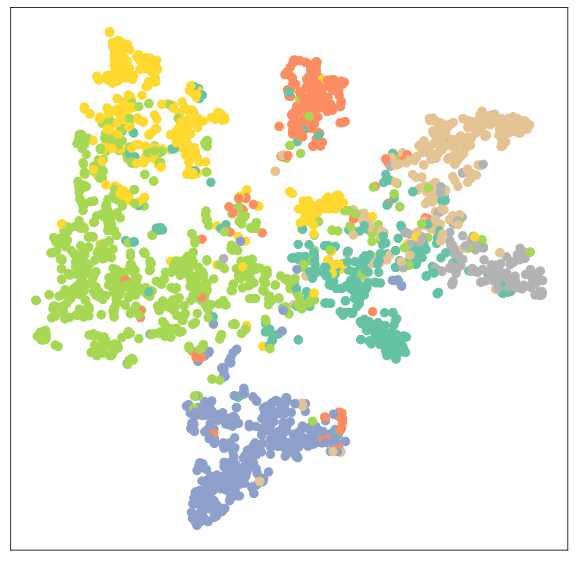

In [64]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)